### Dependencies

In [4]:
!pip3 install torch
!pip install faiss-gpu
!pip install -U sentence-transformers
!pip install laserembeddings

     |████████████████████████████████| 89.4MB 33kB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 2.3MB 11.2MB/s 
     |████████████████████████████████| 1.2MB 47.6MB/s 
     |████████████████████████████████| 3.3MB 54.0MB/s 
     |████████████████████████████████| 901kB 50.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-cp37-none-any.whl size=123338 sha256=704214b49142ffa727854ba42ebb36e8bb08c19af8d55dc0e50898ecf48bae4a
  Stored in directory: /root/.cache/pip/wheels/5e/89/29/45e45adc162b50f97f71801e8b07947c9cfe2b3ae7dbf37896
Successfully built sentence-transformers
     |████████████████████████████████| 860kB 8.7MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp37-none-any.whl size=883999 sha256=59f53f34787c70d9b97e2b462c2df48480f2e7a512f508c7c5efd9a92d55ab7a
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
from sklearn.preprocessing import normalize
import os
import math
from laserembeddings import Laser
import faiss
import itertools
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer, util # LaBSE sentence embedding model
from google.colab import drive

### GPU

In [6]:
# Checks for GPU
if torch.cuda.is_available():
    print('Using GPU: {}'.format(torch.cuda.get_device_name(0)))
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU: Tesla T4


In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


### Loading embedding models

In [8]:
!python -m laserembeddings download-models
laser_model = Laser()
if torch.cuda.is_available():
    print('Using GPU for LASER embeddings')
else:
    print('Using CPU for LASER embeddings')


✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!
Using GPU for LASER embeddings


In [9]:
# Loading LaBSE sentence embedding model
labse_model = SentenceTransformer('LaBSE')
labse_model.cuda() # puts model on GPU

SentenceTransformer(
  (0): Transformer(
    (auto_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(501153, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
      

### Embedding sentences using LaBSE and LASER

### Configuring bitext retrieval task

In [ ]:
GPU = faiss.StandardGpuResources() # enables GPU for similarity search with FAISS

In [ ]:
'''

Params
******
src_emb: array of size number_of_source_sentences X embedding_dimension
tgt_emb: array of size number_of_target_sentences X embedding_dimension
k: number of neighbors to return
batch_size: batch size

Returns
*******
cos_sims: cosine similarity scores for each of k nearest neighbors for each source sentence
inds: target indices of k nearest neighbors for each source sentence

Modeled off of LASER source code: https://github.com/facebookresearch/LASER/blob/master/source/mine_bitexts.py

'''

def knnSearch(src_emb, tgt_emb, k=1, batch_size=1):
    emb_dim = src_emb.shape[1] # Embedding dimension
    num_src_sents = src_emb.shape[0]
    num_tgt_sents = tgt_emb.shape[0]
    cos_sims = np.zeros((num_src_sents, k), dtype=np.float32)
    inds = np.zeros((num_src_sents, k), dtype=np.int64)
    for s_min in range(0, num_src_sents, batch_size):
        s_max = min(s_min + batch_size, num_src_sents)
        src_sims = []
        src_inds = []
        for t_min in range(0, num_tgt_sents, batch_size):
            t_max = min(t_min + batch_size, num_tgt_sents)
            idx = faiss.IndexFlatIP(emb_dim)
            idx = faiss.index_cpu_to_gpu(GPU, 0, idx)
            idx.add(tgt_emb[t_min : t_max])
            src_sim, src_ind = idx.search(src_emb[s_min : s_max], min(k, t_max-t_min))
            src_sims.append(src_sim)
            src_inds.append(src_ind + t_min)
            del idx
        src_sims = np.concatenate(src_sims, axis=1)
        src_inds = np.concatenate(src_inds, axis=1)
        sorted_inds = np.argsort(-src_sims, axis=1)
        for i in range(s_min, s_max):
            for j in range(k):
                cos_sims[i, j] = src_sims[i-s_min, sorted_inds[i-s_min, j]]
                inds[i, j] = src_inds[i-s_min, sorted_inds[i-s_min, j]]
    return cos_sims, inds

In [ ]:
# Retrieves k-nearest neighbor indices and similarity means for margin scoring
# If forward: finds neearest neighbors and indices for all source sentences
# If backward: finds nearest neighbors and indices for all target sentences
# In the approach implemented in our paper, we perform both forward and backward search

def directedMeansAndInds(src_emb, tgt_emb, forward=False, backward=False, k=1, batch_size=1):
    assert forward != backward, "Please choose either forward or backward"
    if forward:
        cos_sims, inds = knnSearch(src_emb, tgt_emb, min(tgt_emb.shape[0], k), batch_size)
        return cos_sims.mean(axis=1), inds
    elif backward:
        cos_sims, inds = knnSearch(tgt_emb, src_emb, min(src_emb.shape[0], k), batch_size)
        return cos_sims.mean(axis=1), inds

In [ ]:
'''

Params
******
pred_tuples: predicted sentence pairs
gold_tuples: ground-truth sentence pairs

Returns
*******
Unweighted F1, precision, recall

'''

def computeF1(pred_tuples, gold_tuples):
    tp = 0 # true positives
    fp = 0 # false positives
    prec = 0
    rec = 0
    f1 = 0
    epsilon = 1e-8 # To prevent division by zero
    for pair in pred_tuples:
        if pair in gold_tuples:
            tp += 1
        else:
            fp += 1 
    prec = tp / (len(pred_tuples) + epsilon)
    rec = tp / len(gold_tuples)
    f1 = 2*prec*rec / (prec+rec+epsilon)
    return f1, prec, rec

In [ ]:
'''

Params
******
src_embs: array of size (number_of_source_sentences * embedding_dimension)
tgt_embs: array of size (number_of_source_sentences * embedding_dimension)
batch_size: batch size
num_neighbors: number of neighbors
average: whether to return a force-aligned average margin score

Returns
*******
concat_pairs: list of mined sentence pairs
margin_scores: list of scores corresponding to mined pairs

'''


def mineSentencePairs(src_embs: list, tgt_embs: list, batch_size=100, num_neighbors=4, average=False):

    # Retrieve means and indices in the forward direction . . .
    fwd_means, fwd_inds = directedMeansAndInds(src_embs, tgt_embs, forward=True, k=num_neighbors, batch_size=batch_size)
    # . . . and in the backward direction
    bwd_means, bwd_inds = directedMeansAndInds(src_embs, tgt_embs, backward=True, k=num_neighbors, batch_size=batch_size)

    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    # We'll sneak this in as an extra capability of this function so we can compute 
    # average margin scores over force-aligned sentence pairs (DV #2)
    margin_scores_aligned = []
    if average:
        for i in range(fwd_inds.shape[0]):
            aligned_margin = (src_embs[i].dot(tgt_embs[i])) / np.average((fwd_means[i], bwd_means[i]))
            margin_scores_aligned.append(aligned_margin)
        return np.average(margin_scores_aligned)
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    
    # else . . .
    fwd_margin_scores = np.zeros(fwd_inds.shape)
    for i in range(fwd_inds.shape[0]):
        for j in range(fwd_inds.shape[1]):
            tgt_ind = fwd_inds[i,j]
            # Compute ratio margin score between each source sentence and each of its k-nearest neighbors
            margin_score = (src_embs[i].dot(tgt_embs[tgt_ind])) / np.average((fwd_means[i], bwd_means[tgt_ind]))
            # Store the result
            fwd_margin_scores[i,j] = margin_score
    
    # We will store the source index, target index, and margin score for the best
    # pairs found using forward search
    best = np.zeros((fwd_inds.shape[0], 3))
    # Take pair that maximizes margin score for each source sentence
    best_inds = fwd_inds[np.arange(src_embs.shape[0]), fwd_margin_scores.argmax(axis=1)]
    for i in range(fwd_inds.shape[0]):
        best_score, ind = (np.max(fwd_margin_scores[i]), np.argmax(fwd_margin_scores[i]))
        best[i] = ((i+1, best_inds[i]+1, best_score)) # Assumption is that GROUND TRUTH VALUES ARE 1-INDEXED!!!

    # Repeat process in backward direction (finding matches in source text for target sentences)
    bwd_margin_scores = np.zeros(bwd_inds.shape)
    for i in range(bwd_inds.shape[0]):
        for j in range(bwd_inds.shape[1]):
            tgt_ind = bwd_inds[i,j]
            margin_score = (tgt_embs[i].dot(src_embs[tgt_ind])) / np.average((bwd_means[i], fwd_means[tgt_ind]))
            bwd_margin_scores[i,j] = margin_score
            
    bwd_best = np.zeros((bwd_inds.shape[0], 3))
    best_inds = bwd_inds[np.arange(tgt_embs.shape[0]), bwd_margin_scores.argmax(axis=1)]
    for i in range(bwd_inds.shape[0]):
        best_score, ind = (np.max(bwd_margin_scores[i]), np.argmax(bwd_margin_scores[i]))
        bwd_best[i] = ((best_inds[i]+1, i+1, best_score))
    
    # Best triples (src_idx, tgt_idx, margin_score) from forward/backward searches
    fwd_best = [tuple(best[i]) for i in range(best.shape[0])]
    bwd_best = [tuple(bwd_best[i]) for i in range(bwd_best.shape[0])]

    pairs_and_scores = []
    # Take INTERSECTION of forward and backward searches
    pairs_and_scores = list(set(fwd_best) & set(bwd_best))

    pairs_and_scores = list(dict.fromkeys(pairs_and_scores))
    concat_pairs = [(triplet[0], triplet[1]) for triplet in pairs_and_scores] # Store indices only
    concat_pairs_int = []
    for tup in concat_pairs:
        concat_pairs_int.append((int(tup[0]), int(tup[1]))) # Ground-truth indices are ints, so change type
    concat_pairs = concat_pairs_int

    margin_scores = [triplet[2] for triplet in pairs_and_scores] # Store scores only

    return concat_pairs, margin_scores

## ECOND-HM

In [10]:
def preprocess_embeddings(vecs: list) -> list:
    
    npvecs = np.vstack(vecs)
    
    # Step 1: Length normalize
    npvecs = normalize(npvecs, axis=1, norm='l2')
    # Step 2: Mean centering
    npvecs = npvecs - npvecs.mean(0)
    # Step 3: Length normalize again
    npvecs = normalize(npvecs, axis=1, norm='l2')
    
    # Return double-normalized and mean-centered vectors
    return npvecs

In [11]:
def computeECOND_HM(embs: list) -> list:
    '''
    See Section 2.1 of "The Secret is in the Spectra" for a mathematical description of this metric, 
    although the implementation below should be easy enough to follow
    '''
    
    EPS = 1e-10
    
    # Obtaining the singular values of each of the bitext embeddings,
    # as done in computing the SVG
    print('Computing SVDs . . .')
    SVD = [np.linalg.svd(emb, compute_uv=False) for emb in tqdm(embs)]
    
    for svd in SVD:
        for i in range(svd.shape[0]):
            if math.isclose(svd[i], 0): svd[i] = EPS
                
    print('Computing ECOND-HMs . . .')
    out = []
    for a,b in tqdm(itertools.combinations(SVD, 2)):
        
        # Computing the entropy of the normalized singular value distribution of
        # each monolingual embedding space
        norm_a = a / sum(a)
        norm_b = b / sum(b)
        norm_a += EPS
        norm_b += EPS
        ent_a = -sum(norm_a * np.log(norm_a))
        ent_b = -sum(norm_b * np.log(norm_b))
        # Computing the effective rank of matrices a and b (see equation (2) in Section 2.1)
        erank_a = int(np.floor(np.exp(ent_a)))
        erank_b = int(np.floor(np.exp(ent_b)))
        # Computing the effective condition number of a and b (see equatino (4) in Section 2.1)
        econd_a = a[0] / a[erank_a-1]
        econd_b = b[0] / b[erank_b-1]
        # Computing the harmonic mean of the effective conditional numbers of a and b
        # (ECOND-HM)
        econd_hm = (2*econd_a*econd_b) / (econd_a+econd_b)
        
        out.append(econd_hm)
    return out

In [50]:
def computeSVG(embs: list) -> list:
    EPS = 1e-10 # For numerical stability with logarithms
    # Computing just the matrices containing the singular values for our embedding spaces
    print('Computing SVDs . . .')
    SVD = [np.linalg.svd(emb, compute_uv=False) for emb in tqdm(embs)]
    
    for svd in SVD:
        for i in range(svd.shape[0]):
            if math.isclose(svd[i], 0): svd[i] = EPS
                
    # See equation (6) in Section 2.2 of the paper linked above
    print('Computing SVGs . . .')
    return [sum((np.log(a[:80,])-np.log(b[:80,]))**2) for a,b in tqdm(itertools.combinations(SVD, 2))]

### Comparing F1-scores on the bitext mining task

## Morphological segmentation experiment

In [ ]:
# English half of Hansard English-Inuktitut parallel corpus
eng_iku_EN = open('drive/My Drive/Cross-lingual alignment proj/english.txt', 'r').read().splitlines()
# Inuktitut half of the same corpus
eng_iku_IK = open('drive/My Drive/Cross-lingual alignment proj/inuktitut_raw.txt', 'r').read().splitlines()
# Morphologically segmented subset of the above set of Inuktitut texts
eng_iku_IK_seg = open('drive/My Drive/Cross-lingual alignment proj/inuktitut_segmented.txt', 'r').read().splitlines()

In [ ]:
# We'll only use this many sentences, since this many have been morphologically parsed
IKU_SENTS_TO_KEEP = len(eng_iku_IK_seg)

In [ ]:
eng_iku_EN = eng_iku_EN[:IKU_SENTS_TO_KEEP-1]
eng_iku_IK = eng_iku_IK[:IKU_SENTS_TO_KEEP-1]
eng_iku_IK_seg = eng_iku_IK_seg[:-1]

In [ ]:
print('Number of English-Inuktitut parallel sentences: {}'.format(len(eng_iku_IK)))

Number of English-Inuktitut parallel sentences: 112190


In [ ]:
eng_iku_en_embs_labse = labse_model.encode(eng_iku_EN[:10000])
eng_iku_ik_embs_labse = labse_model.encode(eng_iku_IK[:10000])
eng_iku_ik_seg_embs_labse = labse_model.encode(eng_iku_IK_seg[:10000])

In [ ]:
eng_iku_en_embs_laser = laser_model.embed_sentences(eng_iku_EN[:10000], 'en')
eng_iku_ik_embs_laser = laser_model.embed_sentences(eng_iku_IK[:10000], '')
eng_iku_ik_seg_embs_laser = laser_model.embed_sentences(eng_iku_IK_seg[:10000], '')

In [ ]:
## LaBSE
# Non-segmented
en_ik_pairs_labse, _ = mineSentencePairs(eng_iku_en_embs_labse, eng_iku_ik_embs_labse)
# Segmented
en_ik_pairs_seg_labse, _ = mineSentencePairs(eng_iku_ik_embs_labse, eng_iku_ik_seg_embs_labse)

In [ ]:
## LASER
# Non-segmented
en_ik_pairs_laser, _ = mineSentencePairs(eng_iku_en_embs_laser, eng_iku_ik_embs_laser)
# Segmented
en_ik_pairs_seg_laser, _ = mineSentencePairs(eng_iku_en_embs_laser, eng_iku_ik_seg_embs_laser)

In [ ]:
en_ik_ground_truth = [(i+1,i+1) for i in range(10000)]

In [ ]:
res1 = computeF1(en_ik_pairs_labse, en_ik_ground_truth)[0]

In [ ]:
res2 = computeF1(en_ik_pairs_seg_labse, en_ik_ground_truth)[0]

In [ ]:
res3 = computeF1(en_ik_pairs_laser, en_ik_ground_truth)[0]

In [ ]:
res4 = computeF1(en_ik_pairs_seg_laser, en_ik_ground_truth)[0]

In [ ]:
print('English-Inuktitut bitext retrieval F1-score (LaBSE, non-segmented): {}'.format(100*round(res1, 5)))
print('English-Inuktitut bitext retrieval F1-score (LaBSE, segmented): {}'.format(100*round(res2, 5)))
print('English-Inuktitut bitext retrieval F1-score (LASER, non-segmented): {}'.format(100*round(res3, 5)))
print('English-Inuktitut bitext retrieval F1-score (LASER, segmented): {}'.format(100*round(res4, 5)))

English-Inuktitut bitext retrieval F1-score (LaBSE, non-segmented): 6.673
English-Inuktitut bitext retrieval F1-score (LaBSE, segmented): 35.503
English-Inuktitut bitext retrieval F1-score (LASER, non-segmented): 0.08
English-Inuktitut bitext retrieval F1-score (LASER, segmented): 0.12


In [ ]:
en_ik_results_labse = pd.DataFrame([res1, res2], columns=['F1-score'], 
                             index=['LaBSE (non-segmented)',
                                    'LaBSE (segmented)'])

In [ ]:
en_ik_results_laser = pd.DataFrame([res3, res4], columns=['F1-score'], 
                             index=['LASER (non-segmented)',
                                    'LASER (segmented)'])

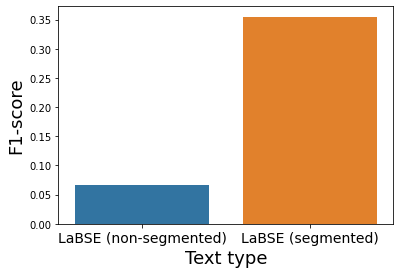

In [ ]:
plt.xlabel('Text type', fontsize=18)
plt.ylabel('F1-score', fontsize=18)
plt.xticks(ticks=[0,1], fontsize=14)
sns.barplot(data=en_ik_results_labse, x=['LaBSE (non-segmented)', 'LaBSE (segmented)'], y='F1-score')
plt.savefig('drive/My Drive/Cross-lingual alignment proj/labse_f1_inuk.png', bbox_inches='tight')

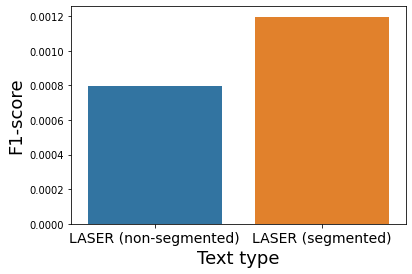

In [ ]:
plt.xlabel('Text type', fontsize=18)
plt.ylabel('F1-score', fontsize=18)
plt.xticks(ticks=[0,1], fontsize=14)
sns.barplot(data=en_ik_results_laser, x=['LASER (non-segmented)', 'LASER (segmented)'], y='F1-score')
plt.savefig('drive/My Drive/Cross-lingual alignment proj/laser_f1_inuk.png', bbox_inches='tight')

# Word order agreement experiment

### PCA

In [20]:
# Verb-initial
kiiche_udhr = open('drive/My Drive/Cross-lingual alignment proj/kiche.txt', 'r').read().splitlines()
mam_udhr = open('drive/My Drive/Cross-lingual alignment proj/mam.txt', 'r').read().splitlines()
chinanteco_udhr = open('drive/My Drive/Cross-lingual alignment proj/chinanteco.txt', 'r').read().splitlines()
tzotzil_udhr = open('drive/My Drive/Cross-lingual alignment proj/tzotzil.txt', 'r').read().splitlines()
mixteco_udhr = open('drive/My Drive/Cross-lingual alignment proj/mixteco.txt', 'r').read().splitlines()
garifuna_udhr = open('drive/My Drive/Cross-lingual alignment proj/garifuna.txt', 'r').read().splitlines()

# Subject-initial
chickasaw_udhr = open('drive/My Drive/Cross-lingual alignment proj/chickasaw.txt', 'r').read().splitlines()
quechua_udhr = open('drive/My Drive/Cross-lingual alignment proj/quechua.txt', 'r').read().splitlines()
achuar_udhr = open('drive/My Drive/Cross-lingual alignment proj/achuar-shiwiar.txt', 'r').read().splitlines()
bambara_udhr = open('drive/My Drive/Cross-lingual alignment proj/bambara.txt', 'r').read().splitlines()
dagaare_udhr = open('drive/My Drive/Cross-lingual alignment proj/dagaare.txt', 'r').read().splitlines()
guarani_udhr = open('drive/My Drive/Cross-lingual alignment proj/guarani.txt', 'r').read().splitlines()

In [21]:
def getSents(file: list, delimiter='.', strip=False):
    out = []
    for par in file:
        for s in par.split(delimiter):
            if s:
                out.append(s)
    return out

In [22]:
kiiche_sents = getSents(kiiche_udhr)
mam_sents = getSents(mam_udhr)
chinanteco_sents = getSents(chinanteco_udhr)
tzotzil_sents = getSents(tzotzil_udhr)
mixteco_sents = getSents(mixteco_udhr)
garifuna_sents = getSents(garifuna_udhr)

chickasaw_sents = getSents(chickasaw_udhr)
quechua_sents = getSents(quechua_udhr)
achuar_sents = getSents(achuar_udhr)
bambara_sents = getSents(bambara_udhr)
dagaare_sents = getSents(dagaare_udhr)
guarani_sents = getSents(guarani_udhr)

In [23]:
kiiche_embs_labse = labse_model.encode(kiiche_sents)
mam_embs_labse = labse_model.encode(mam_sents)
chinanteco_embs_labse = labse_model.encode(chinanteco_sents)
tzotzil_embs_labse = labse_model.encode(tzotzil_sents)
mixteco_embs_labse = labse_model.encode(mixteco_sents)
garifuna_embs_labse = labse_model.encode(garifuna_sents)

chickasaw_embs_labse = labse_model.encode(chickasaw_sents)
quechua_embs_labse = labse_model.encode(quechua_sents)
achuar_embs_labse = labse_model.encode(achuar_sents)
bambara_embs_labse = labse_model.encode(bambara_sents)
dagaare_embs_labse = labse_model.encode(dagaare_sents)
guarani_embs_labse = labse_model.encode(guarani_sents)

In [24]:
kiiche_embs_laser = laser_model.embed_sentences(kiiche_sents, '')
mam_embs_laser = laser_model.embed_sentences(mam_sents, '')
chinanteco_embs_laser = laser_model.embed_sentences(chinanteco_sents, '')
tzotzil_embs_laser = laser_model.embed_sentences(tzotzil_sents, '')
mixteco_embs_laser = laser_model.embed_sentences(mixteco_sents, '')
garifuna_embs_laser = laser_model.embed_sentences(garifuna_sents, '')

chickasaw_embs_laser = laser_model.embed_sentences(chickasaw_sents, '')
quechua_embs_laser = laser_model.embed_sentences(quechua_sents, '')
achuar_embs_laser = laser_model.embed_sentences(achuar_sents, '')
bambara_embs_laser = laser_model.embed_sentences(bambara_sents, '')
dagaare_embs_laser = laser_model.embed_sentences(dagaare_sents, '')
guarani_embs_laser = laser_model.embed_sentences(guarani_sents, '')

In [ ]:
kiiche_pca_labse = PCA(n_components=2).fit_transform(kiiche_embs_labse)
mam_pca_labse = PCA(n_components=2).fit_transform(mam_embs_labse)
chickasaw_pca_labse = PCA(n_components=2).fit_transform(chickasaw_embs_labse)
quechua_pca_labse = PCA(n_components=2).fit_transform(quechua_embs_labse)

kiiche_pca_laser = PCA(n_components=2).fit_transform(kiiche_embs_laser)
mam_pca_laser = PCA(n_components=2).fit_transform(mam_embs_laser)
chickasaw_pca_laser = PCA(n_components=2).fit_transform(chickasaw_embs_laser)
quechua_pca_laser = PCA(n_components=2).fit_transform(quechua_embs_laser)

In [ ]:
pca_sov_langs = 111*['Chickasaw (SOV)'] + 108*['Quechua (SOV)']
pca_nonsov_langs = 107*['K\'iche (VOS)']+97*['Mam (VSO)']

In [ ]:
pc1_labse_sov = list(chickasaw_pca_labse[:,0])+list(quechua_pca_labse[:,0])

In [ ]:
pc1_labse_nonsov = list(kiiche_pca_labse[:,0])+list(mam_pca_labse[:,0])

In [ ]:
pc2_labse_sov = list(chickasaw_pca_labse[:,1])+list(quechua_pca_labse[:,1])

In [ ]:
pc2_labse_nonsov = list(kiiche_pca_labse[:,1])+list(mam_pca_labse[:,1])

In [ ]:
pc1_laser_sov = list(chickasaw_pca_laser[:,0])+list(quechua_pca_laser[:,0])

In [ ]:
pc1_laser_nonsov = list(kiiche_pca_laser[:,0])+list(mam_pca_laser[:,0])

In [ ]:
pc2_laser_sov = list(chickasaw_pca_laser[:,1])+list(quechua_pca_laser[:,1])

In [ ]:
pc2_laser_nonsov = list(kiiche_pca_laser[:,1])+list(mam_pca_laser[:,1])

In [ ]:
pca_df_labse_sov = pd.DataFrame({'PC1 (LaBSE)':pc1_labse_sov, 'PC2 (LaBSE)':pc2_labse_sov, 'Language':pca_sov_langs})

In [ ]:
pca_df_labse_nonsov = pd.DataFrame({'PC1 (LaBSE)':pc1_labse_nonsov, 'PC2 (LaBSE)':pc2_labse_nonsov, 'Language':pca_nonsov_langs})

In [ ]:
pca_df_laser_sov = pd.DataFrame({'PC1 (LASER)':pc1_laser_sov, 'PC2 (LASER)':pc2_laser_sov, 'Language':pca_sov_langs})

In [ ]:
pca_df_laser_nonsov = pd.DataFrame({'PC1 (LASER)':pc1_laser_nonsov, 'PC2 (LASER)':pc2_laser_nonsov, 'Language':pca_nonsov_langs})

<AxesSubplot:xlabel='PC1 (LaBSE)', ylabel='PC2 (LaBSE)'>

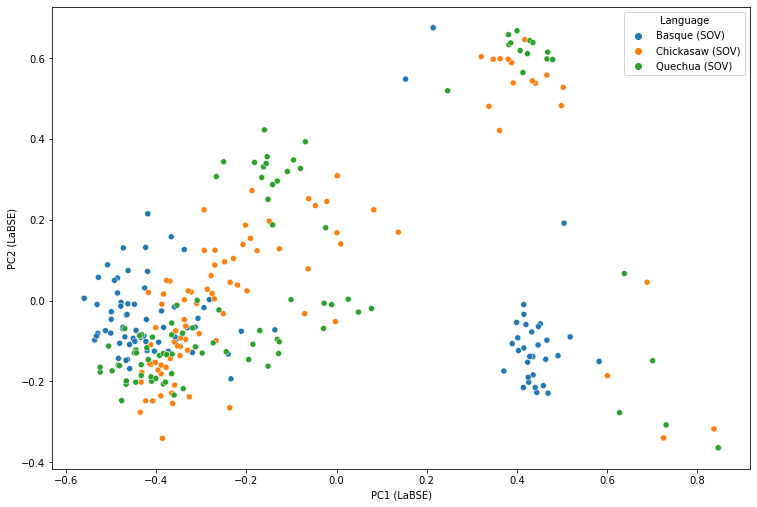

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=pca_df_labse_sov, x='PC1 (LaBSE)', y='PC2 (LaBSE)', hue='Language')

<AxesSubplot:xlabel='PC1 (LASER)', ylabel='PC2 (LASER)'>

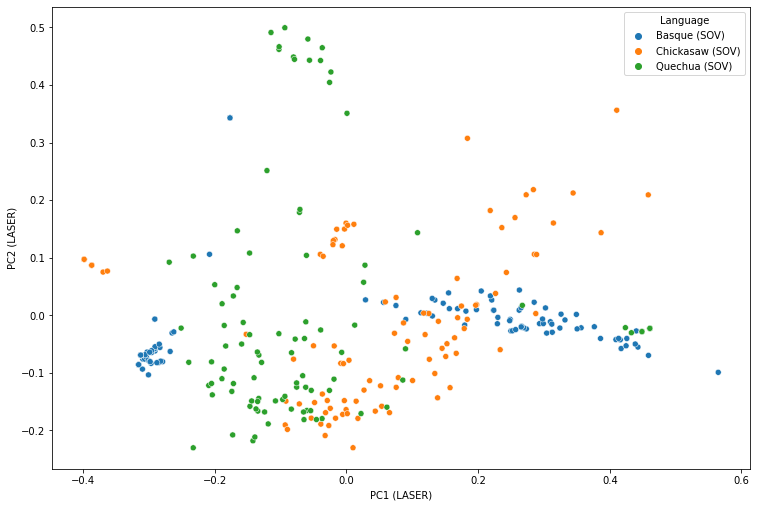

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=pca_df_laser_sov, x='PC1 (LASER)', y='PC2 (LASER)', hue='Language')

<AxesSubplot:xlabel='PC1 (LaBSE)', ylabel='PC2 (LaBSE)'>

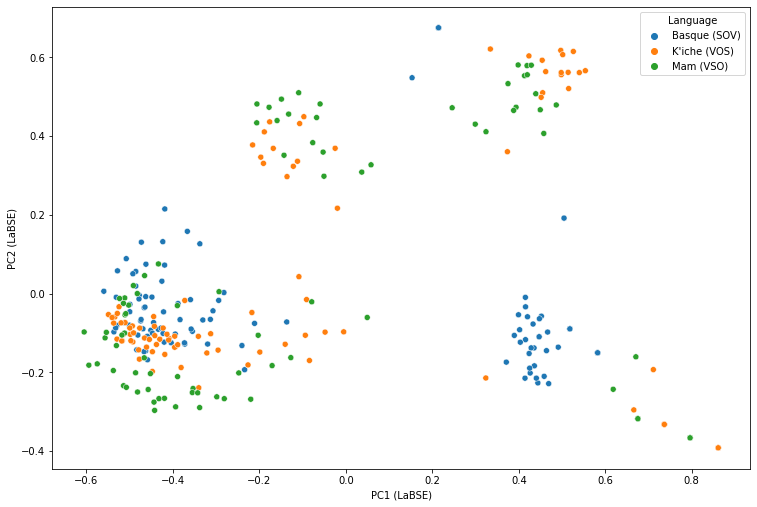

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=pca_df_labse_nonsov, x='PC1 (LaBSE)', y='PC2 (LaBSE)', hue='Language')

<AxesSubplot:xlabel='PC1 (LASER)', ylabel='PC2 (LASER)'>

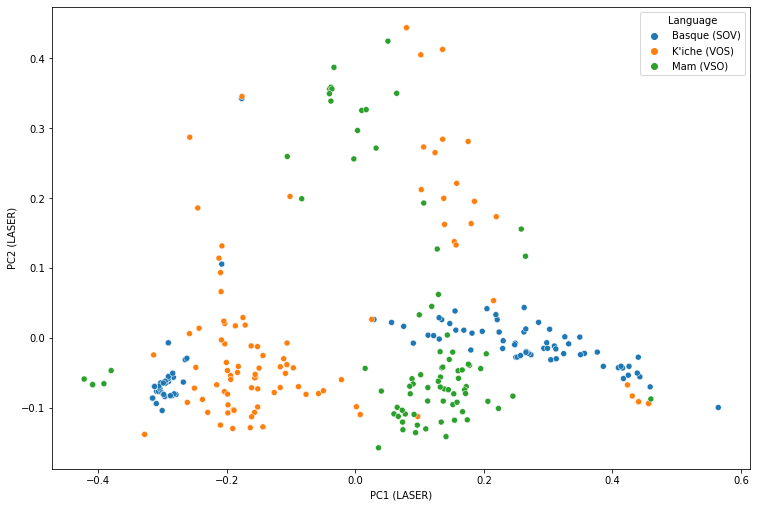

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=pca_df_laser_nonsov, x='PC1 (LASER)', y='PC2 (LASER)', hue='Language')

### t-SNE

In [ ]:
kiiche_tsne_labse = TSNE(n_iter=5000).fit_transform(kiiche_embs_labse)
mam_tsne_labse = TSNE(n_iter=5000).fit_transform(mam_embs_labse)
chickasaw_tsne_labse = TSNE(n_iter=5000).fit_transform(chickasaw_embs_labse)
quechua_tsne_labse = TSNE(n_iter=5000).fit_transform(quechua_embs_labse)

kiiche_tsne_laser = TSNE(n_iter=5000).fit_transform(kiiche_embs_laser)
mam_tsne_laser = TSNE(n_iter=5000).fit_transform(mam_embs_laser)
chickasaw_tsne_laser = TSNE(n_iter=5000).fit_transform(chickasaw_embs_laser)
quechua_tsne_laser = TSNE(n_iter=5000).fit_transform(quechua_embs_laser)

In [ ]:
tsne1_labse_sov = list(chickasaw_tsne_labse[:,0])+list(quechua_tsne_labse[:,0])
tsne1_labse_nonsov = list(kiiche_tsne_labse[:,0])+list(mam_tsne_labse[:,0])

tsne2_labse_sov = list(chickasaw_tsne_labse[:,1])+list(quechua_tsne_labse[:,1])
tsne2_labse_nonsov = list(kiiche_tsne_labse[:,1])+list(mam_tsne_labse[:,1])

tsne1_laser_sov = list(chickasaw_tsne_laser[:,0])+list(quechua_tsne_laser[:,0])
tsne1_laser_nonsov = list(kiiche_tsne_laser[:,0])+list(mam_tsne_laser[:,0])

tsne2_laser_sov = list(chickasaw_tsne_laser[:,1])+list(quechua_tsne_laser[:,1])
tsne2_laser_nonsov = list(kiiche_tsne_laser[:,1])+list(mam_tsne_laser[:,1])

In [ ]:
tsne_df_labse_sov = pd.DataFrame({'t-SNE1 (LaBSE)':tsne1_labse_sov, 
                                 't-SNE2 (LaBSE)':tsne2_labse_sov, 
                                 'Language':pca_sov_langs})
tsne_df_labse_nonsov = pd.DataFrame({'t-SNE1 (LaBSE)':tsne1_labse_nonsov, 
                                    't-SNE2 (LaBSE)':tsne2_labse_nonsov, 
                                    'Language':pca_nonsov_langs})
tsne_df_laser_sov = pd.DataFrame({'t-SNE1 (LASER)':tsne1_laser_sov, 
                                 't-SNE2 (LASER)':tsne2_laser_sov, 
                                 'Language':pca_sov_langs})
tsne_df_laser_nonsov = pd.DataFrame({'t-SNE1 (LASER)':tsne1_laser_nonsov, 
                                    't-SNE2 (LASER)':tsne2_laser_nonsov, 
                                    'Language':pca_nonsov_langs})

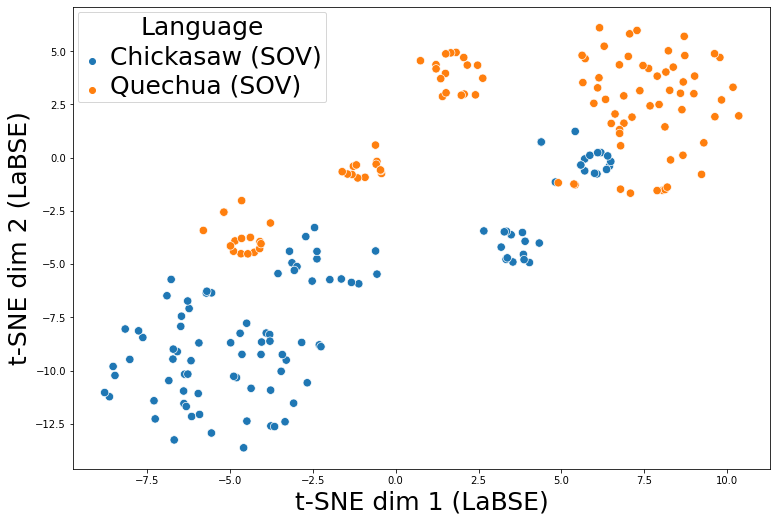

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
ax = sns.scatterplot(data=tsne_df_labse_sov, x='t-SNE1 (LaBSE)', y='t-SNE2 (LaBSE)', hue='Language', s=70)
plt.setp(ax.get_legend().get_title(), fontsize='25')
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.xlabel('t-SNE dim 1 (LaBSE)', fontsize=25)
plt.ylabel('t-SNE dim 2 (LaBSE)', fontsize=25)
plt.savefig('drive/My Drive/Cross-lingual alignment proj/labse_sov.png', bbox_inches='tight')

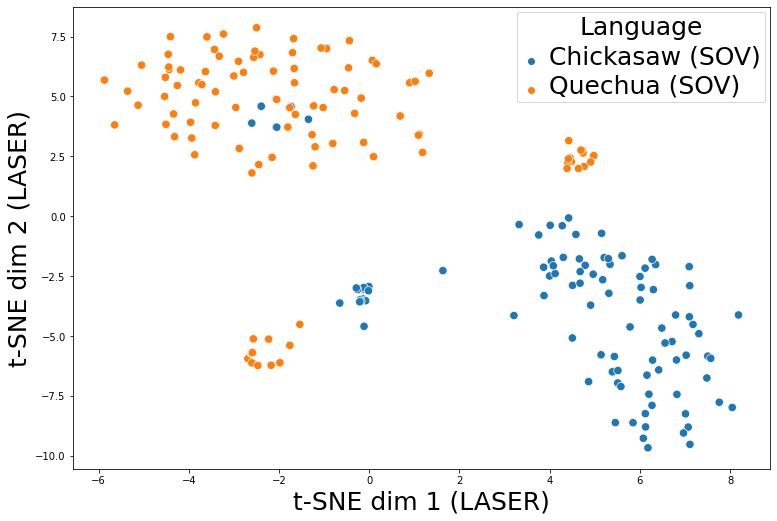

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
ax = sns.scatterplot(data=tsne_df_laser_sov, x='t-SNE1 (LASER)', y='t-SNE2 (LASER)', hue='Language', s=70)
plt.setp(ax.get_legend().get_title(), fontsize='25')
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.xlabel('t-SNE dim 1 (LASER)', fontsize=25)
plt.ylabel('t-SNE dim 2 (LASER)', fontsize=25)
plt.savefig('drive/My Drive/Cross-lingual alignment proj/laser_sov.png', bbox_inches='tight')

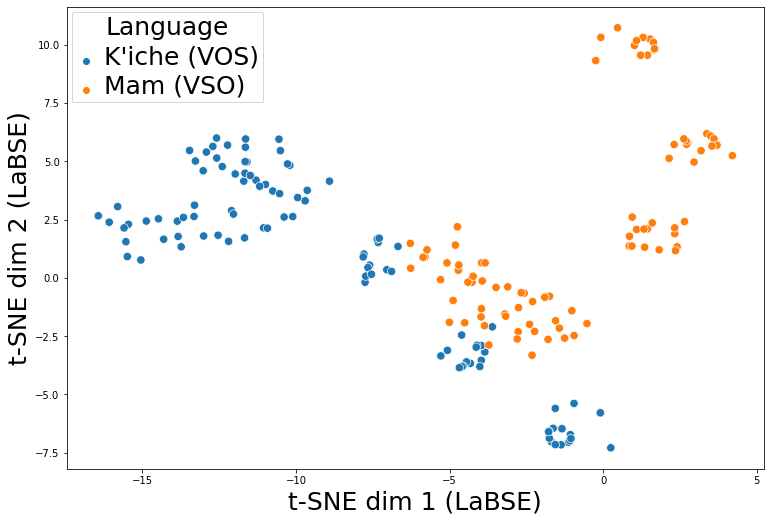

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
ax = sns.scatterplot(data=tsne_df_labse_nonsov, x='t-SNE1 (LaBSE)', y='t-SNE2 (LaBSE)', hue='Language', s=70)
plt.setp(ax.get_legend().get_title(), fontsize='25')
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.xlabel('t-SNE dim 1 (LaBSE)', fontsize=25)
plt.ylabel('t-SNE dim 2 (LaBSE)', fontsize=25)
plt.savefig('drive/My Drive/Cross-lingual alignment proj/labse_nonsov.png', bbox_inches='tight')

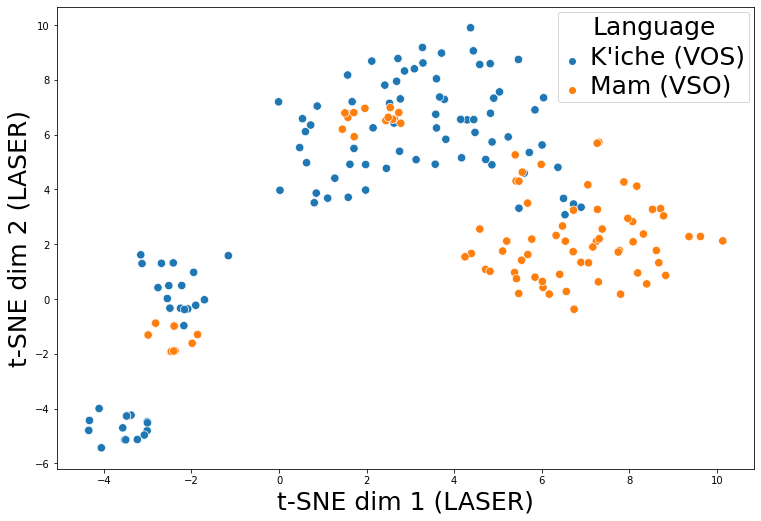

In [ ]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
ax = sns.scatterplot(data=tsne_df_laser_nonsov, x='t-SNE1 (LASER)', y='t-SNE2 (LASER)', hue='Language', s=70)
plt.setp(ax.get_legend().get_title(), fontsize='25')
plt.setp(ax.get_legend().get_texts(), fontsize='25')
plt.xlabel('t-SNE dim 1 (LASER)', fontsize=25)
plt.ylabel('t-SNE dim 2 (LASER)', fontsize=25)
plt.savefig('drive/My Drive/Cross-lingual alignment proj/laser_nonsov.png', bbox_inches='tight')

### ECOND-HM

In [25]:
udhr_langs = ['K\'iche', 'Mam', 'Chinanteco', 'Tzotzil', 'Mixteco', 'Garifuna', 
              'Quechua', 'Chickasaw', 'Achuar-Shiwiar', 'Bambara', 'Dagaare', 'Guarani']
              
labse_udhr = [kiiche_embs_labse, mam_embs_labse, chinanteco_embs_labse, tzotzil_embs_labse, mixteco_embs_labse, garifuna_embs_labse, 
              quechua_embs_labse, chickasaw_embs_labse, achuar_embs_labse, bambara_embs_labse, dagaare_embs_labse, guarani_embs_labse]

laser_udhr = [kiiche_embs_laser, mam_embs_laser, chinanteco_embs_laser, tzotzil_embs_laser, mixteco_embs_laser, garifuna_embs_laser, 
              quechua_embs_laser, chickasaw_embs_laser, achuar_embs_laser, bambara_embs_laser, dagaare_embs_laser, guarani_embs_laser]

In [26]:
labse_udhr_proc = [preprocess_embeddings(embs) for embs in labse_udhr]
laser_udhr_proc = [preprocess_embeddings(embs) for embs in laser_udhr]

In [51]:
labse_udhr_econdhm = computeECOND_HM(labse_udhr_proc)
laser_udhr_econdhm = computeECOND_HM(laser_udhr_proc)

labse_udhr_svg = computeSVG(labse_udhr_proc)
laser_udhr_svg = computeSVG(laser_udhr_proc)


100%|██████████| 12/12 [00:00<00:00, 130.80it/s]

66it [00:00, 13467.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Computing SVDs . . .
Computing SVGs . . .
Computing SVDs . . .



100%|██████████| 12/12 [00:00<00:00, 98.02it/s] 

66it [00:00, 11969.74it/s]

Computing SVGs . . .


In [52]:
labse_econdhm_dict = {}
i = 0
for l1, l2 in itertools.combinations(udhr_langs, 2):
  lang_pair = l1 + '-' + l2
  labse_econdhm_dict[lang_pair] = labse_udhr_econdhm[i]
  i+=1

labse_svg_dict = {}
i = 0
for l1, l2 in itertools.combinations(udhr_langs, 2):
  lang_pair = l1 + '-' + l2
  labse_svg_dict[lang_pair] = labse_udhr_svg[i]
  i+=1

In [53]:
laser_econdhm_dict = {}
i = 0
for l1, l2 in itertools.combinations(udhr_langs, 2):
  lang_pair = l1 + '-' + l2
  laser_econdhm_dict[lang_pair] = laser_udhr_econdhm[i]
  i+=1

laser_svg_dict = {}
i = 0
for l1, l2 in itertools.combinations(udhr_langs, 2):
  lang_pair = l1 + '-' + l2
  laser_svg_dict[lang_pair] = laser_udhr_svg[i]
  i+=1

In [30]:
laser_econdhm_dict

{'Achuar-Shiwiar-Bambara': 18.784964858228548,
 'Achuar-Shiwiar-Dagaare': 21.015969477207758,
 'Achuar-Shiwiar-Guarani': 24.475368403925163,
 'Bambara-Dagaare': 15.28584726372071,
 'Bambara-Guarani': 17.03736164417756,
 'Chickasaw-Achuar-Shiwiar': 19.478108562102936,
 'Chickasaw-Bambara': 14.45570979150221,
 'Chickasaw-Dagaare': 15.741681294667686,
 'Chickasaw-Guarani': 17.605584777620845,
 'Chinanteco-Achuar-Shiwiar': 25.14793777224775,
 'Chinanteco-Bambara': 17.36056046839617,
 'Chinanteco-Chickasaw': 17.95092003377759,
 'Chinanteco-Dagaare': 19.249047584745504,
 'Chinanteco-Garifuna': 18.656258066867338,
 'Chinanteco-Guarani': 22.111582520765584,
 'Chinanteco-Mixteco': 19.45520612224316,
 'Chinanteco-Quechua': 18.01383262255195,
 'Chinanteco-Tzotzil': 22.333675203721526,
 'Dagaare-Guarani': 18.852511880862412,
 'Garifuna-Achuar-Shiwiar': 20.31134926074818,
 'Garifuna-Bambara': 14.909642599149759,
 'Garifuna-Chickasaw': 15.342997344556256,
 'Garifuna-Dagaare': 16.281476572552677,
 'G

In [31]:
labse_econdhm_dict

{'Achuar-Shiwiar-Bambara': 19.09748987182285,
 'Achuar-Shiwiar-Dagaare': 22.90227187924349,
 'Achuar-Shiwiar-Guarani': 21.52935289531027,
 'Bambara-Dagaare': 16.25956603553501,
 'Bambara-Guarani': 15.555322584515503,
 'Chickasaw-Achuar-Shiwiar': 21.83025167597584,
 'Chickasaw-Bambara': 15.711794190786087,
 'Chickasaw-Dagaare': 18.199241617444297,
 'Chickasaw-Guarani': 17.32148558297736,
 'Chinanteco-Achuar-Shiwiar': 24.453261234049698,
 'Chinanteco-Bambara': 17.026262213934906,
 'Chinanteco-Chickasaw': 19.165205179209895,
 'Chinanteco-Dagaare': 19.986533185946445,
 'Chinanteco-Garifuna': 18.187899632373487,
 'Chinanteco-Guarani': 18.9328987006001,
 'Chinanteco-Mixteco': 18.279101795925943,
 'Chinanteco-Quechua': 18.361514990188816,
 'Chinanteco-Tzotzil': 19.621442024912323,
 'Dagaare-Guarani': 17.98963433664263,
 'Garifuna-Achuar-Shiwiar': 20.57117299712273,
 'Garifuna-Bambara': 15.048869145520829,
 'Garifuna-Chickasaw': 16.695808964778717,
 'Garifuna-Dagaare': 17.315696900349554,
 'Ga

In [32]:
word_order_dict = {'Chickasaw': 'subject-initial', 'Quechua': 'subject-initial', 'Achuar-Shiwiar': 'subject-initial',
                   'Bambara': 'subject-initial', 'Dagaare': 'subject-initial', 'Guarani': 'subject-initial',
                   'K\'iche': 'verb-initial', 'Mam': 'verb-initial', 'Chinanteco': 'verb-initial', 'Tzotzil': 'verb-initial',
                   'Mixteco': 'verb-initial', 'Garifuna': 'verb-initial'}

In [62]:
labse_same, labse_different = [], []
i = 0
for l1, l2 in itertools.combinations(udhr_langs, 2):
  if word_order_dict[l1]==word_order_dict[l2]:
    labse_same.append(labse_udhr_econdhm[i])
  else:
    labse_different.append(labse_udhr_econdhm[i])
  i+=1

In [63]:
np.average(labse_same)

18.07612384147392

In [64]:
np.average(labse_different)

18.132704343767095

In [65]:
laser_same, laser_different = [], []
i = 0
for l1, l2 in itertools.combinations(udhr_langs, 2):
  if word_order_dict[l1]==word_order_dict[l2]:
    laser_same.append(laser_udhr_econdhm[i])
  else:
    laser_different.append(laser_udhr_econdhm[i])
  i+=1

In [66]:
np.average(laser_same)

18.129297139050937

In [67]:
np.average(laser_different)

18.200603815905655